In [95]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import math as math
import itertools
import os
import scipy
from scipy.optimize import curve_fit
from scipy.special import wofz

In [43]:
def process_csv(file_path):  # function for reading in a csv and returning two arrays, x and y
    x = []
    y = []

    with open(file_path, 'r') as csvfile:
        csvreader = csv.reader(csvfile)

        for _ in range(22):   # skip the first 22 lines (not data)
            next(csvreader)

        for row in csvreader:
            x.append(float(row[0]))
            y.append(float(row[2]))

    return x, y

def plot_data(x, y, file_name, color):               # function for plotting quickly
    plt.plot(x, y, label=file_name, color=color)

1.88_80_MeV.csv
2.3_55_MeV.csv


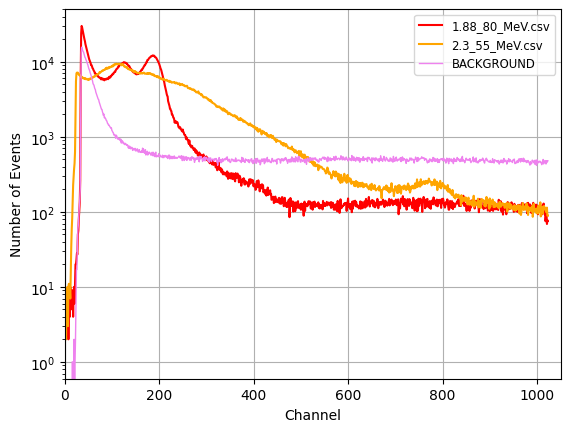

842481.0
[1891301.0, 2203468.0]


In [85]:
fig, ax = plt.subplots()
plt.xlabel('Channel')
plt.ylabel('Number of Events')

folder = './CSVs/main/'                                       # where the CSVs I want to read are
colors, i = ['red', 'orange', 'yellow', 'blue', 'green'], 0   # colors of plots
cross_sections= []                                            # initialize array for summing up the background events

back_x, back_y = process_csv('background_2.0_MeV.csv')        # reading in the background data
background_CS = 0

for j in range(len(back_y)):
    background_CS = background_CS + back_y[j]                 # summing all the background events

for file_name in os.listdir(folder):                          # processing the non-background data
    print(file_name)
    x, y = process_csv(folder+file_name)

    plot_data(x, y, file_name, colors[i])                     # plot the non-background data
    i = i+1

    total = 0
    for j in range(len(y)):
        total = total + y[j]            # sum the total events, background included

    cross_sections.append(total)        # array that stores the total number of events as a fucntion of proton energy

plt.plot(back_x, back_y, label='BACKGROUND', linewidth=1, color='violet')  # plot the background

plt.legend(loc='upper right')
plt.yscale('log')
plt.legend(fontsize='small')
plt.xlim(0,1050)
plt.grid('True')
#plt.savefig('./Figures/main.pdf',dpi=100,bbox_inches='tight')      # NAME FILE
plt.show()

print(background_CS)
print(cross_sections)

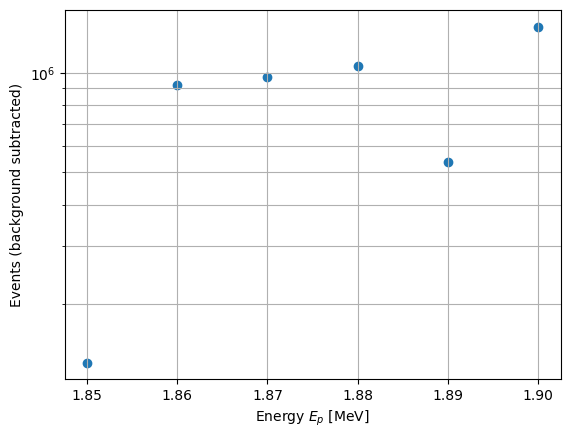

In [124]:
xdata, ydata = [], []

with open('resonance', 'r') as csvfile:   # 'resonance' has all the events for spectra at the desired energies
    csvreader = csv.reader(csvfile)

    # Read the data from the CSV
    for row in csvreader:
        xdata.append(float(row[0]))                # energy array
        ydata.append(float(row[1])-background_CS)  # for each datapoint, subtract the background

fig, ax = plt.subplots()                           # plotting
plt.yscale('log')
plt.grid(True)
plt.xlabel(r'Energy $E_{p}$ [MeV]')
plt.ylabel('Events (background subtracted)')
plt.grid(True, which='both', axis='y')
plt.grid(True, which='both', axis='x')
plt.scatter(xdata, ydata)
#plt.savefig('./Figures/energy_vs_events.pdf',dpi=100,bbox_inches='tight')      # NAME FILE

1.1211381431089629 +- 0.2397290386014712
1.849436075199855 +- 0.0022748363115358827


C:\Users\kylem\AppData\Local\Temp\ipykernel_12116\1972125125.py:2: RuntimeWarning: invalid value encountered in sqrt
  x = C * np.sqrt(1-Eth/Ep)


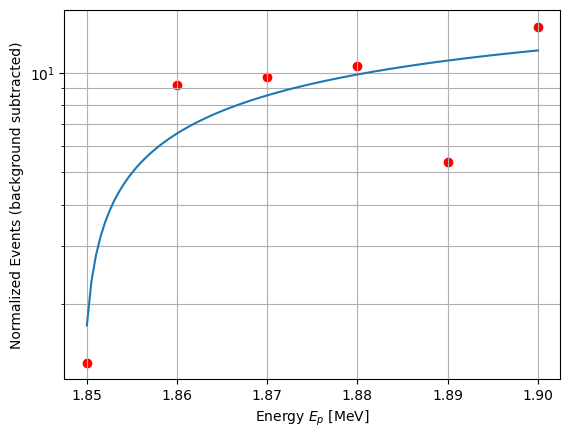

In [125]:
def func(Ep,C,Eth):                     # fit the data to the Breit Wigner
    x = C * np.sqrt(1-Eth/Ep)
    return 169.72/Ep * x/(1+x)**2

initial_guess = [1, 1]   # sigma, gamma guess

for i in range(len(ydata)):
    ydata[i] = ydata[i]/1e5

popt, pcov = curve_fit(func, xdata, ydata, p0=initial_guess)
C, Eth = popt
C_err, Eth_err = np.sqrt(pcov[0][0]), np.sqrt(pcov[1][1])

print(C, '+-', C_err)
print(Eth, '+-', Eth_err)

x_array = np.linspace(min(xdata), max(xdata), 100)
y_fit = [func(i, C, Eth) for i in x_array]  # get fitted curve

fig, ax = plt.subplots()
plt.yscale('log')
plt.grid(True)
plt.xlabel(r'Energy $E_{p}$ [MeV]')
plt.ylabel('Normalized Events (background subtracted)')
plt.grid(True, which='both', axis='y')
plt.grid(True, which='both', axis='x')
plt.scatter(xdata, ydata, color='red')
plt.plot(x_array, y_fit)
#plt.savefig('./Figures/resonance_fit.pdf',dpi=100,bbox_inches='tight')      # NAME FILE

In [128]:
for i in range(len(x_array)):    # figure out the cross-section at our 1.88 resonance 
    if x_array[i] > 1.88:
        print(y_fit[i])
        break

9.913212316466588


In [136]:
# Error props & width calcs

def gamma_p(E, C):
    K = 1e5
    m_p = 1.67262192e-27
    V = 9.913212316466588
    h = 1

    result = math.sqrt((16 * K * 1.88 * m_p * V * (1 + C * math.sqrt(1 - E/1.88))**2) / (5 * h**2 * C * math.sqrt(1 - E/1.88)))

    return result

def partial_derivative_gamma_p(E, C):
    K = 1e5
    m_p = 1.67262192e-27
    V = 9.913212316466588
    h = 1

    result = math.sqrt((4 * K * m_p * V * C) / (5 * h**2)) * \
             (-0.53191 + (0.26595 * (math.sqrt(-0.53191 * E + 1) + 1)) / math.sqrt(-0.53191 * E + 1)) / \
             (-0.53191 * E + 1)**(3/4)

    return result

def partial_derivative_gamma_p_C(E, C):
    K = 1e5
    m_p = 1.67262192e-27
    V = 9.913212316466588
    h = 1

    result = math.sqrt((4 * K * m_p * V) / (5 * h**2 * C**5)) * \
             (-0.53191 * C**2 * E + C**2 - 1) / \
             ((math.sqrt(-0.53191 * E + 1) + 1) * (-0.53191 * E + 1)**(1/4))

    return result

In [141]:
E = 1.849
E_err = 0.002
C = 1.1
C_err = 0.2

print('P res', gamma_p(1.849, 1.1)) # gamm_{p}

gam_p_err = partial_derivative_gamma_p_C(E, C)*C_err + partial_derivative_gamma_p(E, C)*E_err

print('Err', gam_p_err) # Gam_{p} err

print('n res', 3.032803396523122e-10* 1.1 * np.sqrt(1- 1.849/1.88)) #gamma_{n}

gam_n_err = gam_p_err * 1.1 * np.sqrt(1- 1.849/1.88)

print('Err', gam_n_err)  # gamma_{n} err

print('total', 3.032803396523122e-10 + 4.2838954703584385e-11) # total gamma

print('err', gam_p_err + gam_n_err)

P res 3.032803396523122e-10
Err -1.0914353826766959e-11
n res 4.2838954703584385e-11
Err -1.541674312749003e-12
total 3.461192943558966e-10
err -1.2456028139515962e-11
